In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as utils
import numpy as np
from matplotlib import pyplot as plt

In [28]:
data_root = './data/fashionMNIST'
image_size = 28
in_channels = 1
num_classes = 10
num_fm = 1024
batch_size = 128
workers = 4
num_epochs = 10

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

if device.type == "cuda":
    print("Using %d GPUs." % (n_gpu))
else:
    print("Using CPU.")

Using 1 GPUs.


In [30]:
data = dset.FashionMNIST(data_root, transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            download=True)

In [31]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [32]:
test_data = dset.FashionMNIST(data_root, transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
            train=False,
            download=True)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [33]:
num_to_label = ["tshirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle_boot"]

Let's have a quick look at the example batch!

In [34]:
batch_img, batch_label = next(iter(dataloader))

In [35]:
my_grid = utils.make_grid(batch_img, nrow=12, normalize=True)

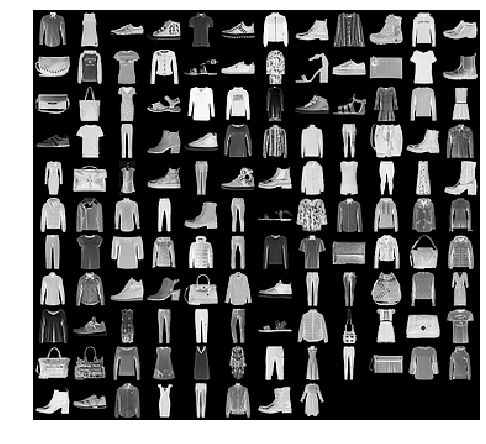

In [36]:
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(my_grid, (1, 2, 0)))
plt.axis("off")
plt.show()

In [37]:
print([num_to_label[batch_label[int(i)]] for i in range(len(batch_label))])

['shirt', 'tshirt', 'sneaker', 'sneaker', 'tshirt', 'sneaker', 'coat', 'ankle_boot', 'coat', 'ankle_boot', 'pullover', 'ankle_boot', 'bag', 'pullover', 'tshirt', 'coat', 'sandal', 'sneaker', 'coat', 'sandal', 'sneaker', 'bag', 'tshirt', 'ankle_boot', 'bag', 'bag', 'dress', 'sandal', 'pullover', 'pullover', 'dress', 'sneaker', 'sandal', 'dress', 'pullover', 'dress', 'sneaker', 'tshirt', 'trouser', 'ankle_boot', 'sneaker', 'pullover', 'shirt', 'pullover', 'trouser', 'bag', 'ankle_boot', 'coat', 'dress', 'bag', 'dress', 'sneaker', 'trouser', 'sneaker', 'ankle_boot', 'coat', 'tshirt', 'trouser', 'dress', 'ankle_boot', 'coat', 'coat', 'shirt', 'trouser', 'ankle_boot', 'trouser', 'sandal', 'shirt', 'shirt', 'pullover', 'coat', 'pullover', 'trouser', 'tshirt', 'shirt', 'coat', 'coat', 'trouser', 'pullover', 'shirt', 'bag', 'coat', 'bag', 'coat', 'shirt', 'coat', 'sneaker', 'ankle_boot', 'bag', 'shirt', 'sneaker', 'trouser', 'trouser', 'bag', 'pullover', 'dress', 'pullover', 'sneaker', 'dress'

In [38]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, int(num_fm/4), 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14x14
            
            nn.Conv2d(int(num_fm/4), int(num_fm/2), 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), #7x7
            
            nn.Conv2d(int(num_fm/2), int(num_fm), 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)) # 3x3
        
        self.classifier = nn.Sequential(
            nn.Linear(3*3*num_fm, 2048),
            nn.ReLU(),
            
            nn.Linear(2048, 2048),
            nn.ReLU(),
            
            nn.Linear(2048, num_classes))
            
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 3*3*num_fm)
        x = self.classifier(x)
        return x

In [39]:
model = CNN()
model = model.to(device)
if (device.type == "cuda" and (n_gpu > 1)):
    model = nn.DataParallel(model)

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

Start Training Loop

In [41]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        model.zero_grad()
        batch_img, batch_label = data
        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)
        output = model(batch_img)
        loss = criterion(output, batch_label)
        loss.backward()
        optimizer.step()
        
        if i%50 == 0:
            print("[%d / %d]\t[%d / %d] Loss: %.4f" % (epoch, num_epochs, i, len(dataloader), loss))

[0 / 10]	[0 / 469] Loss: 2.3013
[0 / 10]	[50 / 469] Loss: 0.7793
[0 / 10]	[100 / 469] Loss: 0.6839
[0 / 10]	[150 / 469] Loss: 0.5848
[0 / 10]	[200 / 469] Loss: 0.4989
[0 / 10]	[250 / 469] Loss: 0.3744
[0 / 10]	[300 / 469] Loss: 0.4741
[0 / 10]	[350 / 469] Loss: 0.3835
[0 / 10]	[400 / 469] Loss: 0.2911
[0 / 10]	[450 / 469] Loss: 0.3152
[1 / 10]	[0 / 469] Loss: 0.2077
[1 / 10]	[50 / 469] Loss: 0.2864
[1 / 10]	[100 / 469] Loss: 0.3107
[1 / 10]	[150 / 469] Loss: 0.2444
[1 / 10]	[200 / 469] Loss: 0.1868
[1 / 10]	[250 / 469] Loss: 0.2109
[1 / 10]	[300 / 469] Loss: 0.2936
[1 / 10]	[350 / 469] Loss: 0.3429
[1 / 10]	[400 / 469] Loss: 0.2696
[1 / 10]	[450 / 469] Loss: 0.2539
[2 / 10]	[0 / 469] Loss: 0.2036
[2 / 10]	[50 / 469] Loss: 0.2709
[2 / 10]	[100 / 469] Loss: 0.1602
[2 / 10]	[150 / 469] Loss: 0.1958
[2 / 10]	[200 / 469] Loss: 0.2771
[2 / 10]	[250 / 469] Loss: 0.1547
[2 / 10]	[300 / 469] Loss: 0.3312
[2 / 10]	[350 / 469] Loss: 0.1822
[2 / 10]	[400 / 469] Loss: 0.2460
[2 / 10]	[450 / 469] Lo

Process Process-113:
Process Process-116:
Process Process-115:
Process Process-114:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/is/sg/mniemeyer/.local/lib/python

KeyboardInterrupt: 

In [ ]:
confusion = np.zeros((10,10))

for i, data in enumerate(test_dataloader, 0):
    test_img, test_label = data
    test_img = test_img.to(device)
    test_label = test_label.to(device)
    
    predicted_labels = model(test_img)
    _, predicted_labels = torch.max(predicted_labels, 1)
    
    for l in range(len(test_label)):
        confusion[test_label[l], predicted_labels[l]] += 1    

In [ ]:
print(confusion)
plt.imshow(confusion, cmap="hot")
plt.savefig('./output/fashion_mnist_confusion.png')

Most common mistake is to take class 0 for class 6, which means t-shirt for shirt

In [ ]:
c_sum = confusion.sum(axis=1)
accuracy = np.trace(confusion/c_sum)/10
print("We have an average accuracy of %.4f" % (accuracy))